<a href="https://colab.research.google.com/github/VolkhinD/brain_tumor/blob/main/kaggle_brain_tumor_with_pytorch_and_pre_trained_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Start

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
import pandas as pd
from skimage.io import imread
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import tqdm
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
path_to_csv = '/content/drive/MyDrive/Data/Brain Tumor.csv'
path_to_img = '/content/drive/MyDrive/Data/Brain Tumor'
data = pd.read_csv(path_to_csv, usecols=[0,1])

train_val_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=45)
train_data, val_data = train_test_split(train_val_data, test_size = 0.2, shuffle=True, random_state=45)
img_data = {'train': train_data, 'val': val_data, 'test': test_data, 'trainval': train_val_data}

torch.Size([3, 240, 240])
Image1
Image label is  0


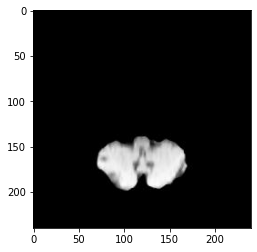

In [29]:
#Take a look to a sampler Image
path_to_example_image = '/content/drive/MyDrive/Data/Brain Tumor/Image1.jpg'

img1 = torchvision.io.read_image(path_to_example_image) # The torchvision.io package provides functions for performing IO operations.
                                                        # I use the torchvision.io.read_image() function to load our image into a tensor 

print(img1.shape)
import matplotlib.pyplot as plt
#If we want to display our image with matplotlib we need to transform the image format from [3, 240, 240] to [240, 240, 3].
#To do this we use the permute() function which allows us to move the dimensions of a tensor.
plt.imshow(img1.permute((1,2,0)))
print(data.loc[0][0])
print("Image label is ", data.loc[0][1])

# Custom Dataset

Create a custom dataset to load data and much image names and their labeles. A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.

In [30]:
class ImgDataSet(Dataset):
    def __init__(self, csv_file, transform): 
        self.transform = transform
        self.csv_file = csv_file # pandas DataFrame which contains Image names and their labels
        self.img_folder = '/content/drive/MyDrive/Data/Brain Tumor' # path to folder with images
        self.img_names = self.csv_file[:]['Image'].tolist()
        self.labels = self.csv_file[:]['Class'].tolist()
    

#The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        path = os.path.join(self.img_folder, str(self.img_names[index]) + '.jpg')

        image = torchvision.io.read_image(path)
        image=self.transform(image)
        target=self.labels[index]

        sample = (image, target)

        return sample


__getitem__ loads and returns a sample from the dataset at the given index. Based on the index, it identifies the image’s location on disk, converts that to a tensor, retrieves the corresponding label, calls the transform functions on them, and returns the tensor image and corresponding label in a tuple.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. [Source](https://pytorch.org/hub/pytorch_vision_resnet/)

In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transform = {'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224), # Resizing the image to be 224 by 224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                transforms.Normalize(mean, std)
        ]),
              'val': transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)
        ]),
              'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224),
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)
        ]),    
              'trainval': transforms.Compose([
                transforms.ToPILImage(),
                transforms.CenterCrop(224), 
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)])}

datasets = {x: ImgDataSet(img_data[x], transform=data_transform[x]) for x in ['train', 'val', 'test', 'trainval']}

dataloaders = {x: DataLoader(datasets[x], batch_size=4, shuffle=True)  for x in ['train', 'val', 'test', 'trainval']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test', 'trainval']}

for x in ['train', 'val', 'test', 'trainval']:
    print(f'{x} size is {dataset_sizes[x]}')

train size is 2407
val size is 602
test size is 753
trainval size is 3009


In [32]:
ex = datasets['train'][0]

# Train and Test Functions

In [56]:
def try_small_sample(model, creterion, optimizer):
    """ Takes 1 batch (size 4) and tries to overfit a model"""
  
    model.train()
# I copied work form Google Colab and it ueses 2 spaces instead of 4 
    sam_img, sam_labels = next(iter(dataloaders['train']))
    sam_img, sam_labels = sam_img.to(device), sam_labels.to(device)

    for epoch in range(1000):
        outputs = model(sam_img)
        loss = creterion(outputs, sam_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch № {epoch + 1}, loss is {loss.item()}' )
  
    return

def test_model(model):

    model.eval()

    running_corrects = 0

    for inputs, labels in dataloaders['test']:
      inputs, labels = inputs.to(device), labels.to(device)
    
      with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    
    acc = running_corrects.double()/dataset_sizes['test']

    return round(acc.item(), 5)


def set_seed(n):
    random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)

In [109]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 5):
    
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

              
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # forward
            
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

          
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

          
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train' and scheduler != None:
                      scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

# 1 Approach:
Train a whole model, apply learning rate schedular so every 5 steps learning rate decreased by 10 times.

## 1 Approach with ResNet-18

In [110]:
set_seed(42)
model_1 = models.resnet18(pretrained=True)
num_of_inputfeatures = model_1.fc.in_features # number of input features for the last layer we need
# create a new fc layer
model_1.fc = nn.Linear(num_of_inputfeatures, 2)
#model.to(device)

creterion = nn.CrossEntropyLoss().to(device)
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.01)
model_1.to(device)
step_lr_shcedular = lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1) #every 2 steps lr multiplyed by 0.1


In [111]:
test_model(model_1)

0.46746

In [112]:
model_1 = train_model(model_1, creterion, optimizer_1, step_lr_shcedular)

Epoch 1/5
----------
train Loss: 1.4376 Acc: 0.5521

val Loss: 0.6466 Acc: 0.5399

Epoch 2/5
----------
train Loss: 1.3499 Acc: 0.5505

val Loss: 0.7493 Acc: 0.5332

Epoch 3/5
----------
train Loss: 1.3516 Acc: 0.5509

val Loss: 0.6573 Acc: 0.5332

Epoch 4/5
----------
train Loss: 1.3728 Acc: 0.5492

val Loss: 0.7358 Acc: 0.5332

Epoch 5/5
----------
train Loss: 1.4661 Acc: 0.5480

val Loss: 0.7010 Acc: 0.5349

Training complete in 1m 53s


In [105]:
test_model(model_1)

0.84197

Result after 20 epochs: 0.71448 and learning rate was redused every 2 steps by 10 times

## 1 Approach with Alexnet

According to [this](https://learnopencv.com/transfer-learning-for-medical-images/#:~:text=ImageNet%20pretrained%20weights%20produce%20better%20results%20in%20chest%20X%2DRay%20data.) AlexNet is a very popular choise for brain MRI so I decided to consider it. Note that I decresed learning rate by 10 times and used SGD optimizer 

In [116]:
set_seed(16)
alexnet_1 = models.alexnet(pretrained = True)
alexnet_1.classifier[4] = nn.Linear(4096, 1024) # update the second classifier
#RELU
alexnet_1.classifier[6] = nn.Linear(1024, 2)
alexnet_1.to(device)
alx_optimizer_1 = optim.SGD(alexnet_1.parameters(), lr=0.001)
alx_schedular_1 = lr_scheduler.StepLR(alx_optimizer_1, step_size=5, gamma=0.1)
alx_creterion_1 = nn.CrossEntropyLoss().to(device)

In [117]:
test_model(alexnet_1)

0.46348

In [118]:
alexnet_1 = train_model(alexnet_1, alx_creterion_1, alx_optimizer_1, alx_schedular_1)

Epoch 1/5
----------
train Loss: 0.6877 Acc: 0.5721

val Loss: 0.6469 Acc: 0.6262

Epoch 2/5
----------
train Loss: 0.6728 Acc: 0.5953

val Loss: 0.6469 Acc: 0.6262

Epoch 3/5
----------
train Loss: 0.6809 Acc: 0.5895

val Loss: 0.6469 Acc: 0.6262

Epoch 4/5
----------
train Loss: 0.6909 Acc: 0.5758

val Loss: 0.6469 Acc: 0.6262

Epoch 5/5
----------
train Loss: 0.6774 Acc: 0.5808

val Loss: 0.6469 Acc: 0.6262

Training complete in 1m 32s


In [119]:
test_model(alexnet_1)

0.66534

Result after 20 epochs: 0.73307 and learning rate was redused every 10 steps by 10 times

# 2 Approach:
Add one more linear layer to model and train only new one. Also apply learning rate schedular, so every 5 epoch lr decreases by 10 times

## 2 Approach with ResNet-18

In [123]:
set_seed(42)
model_2 = models.resnet18(pretrained=True)
for param in model_2.parameters():
      param.requires_grad = False

num_in_feat = model_2.fc.in_features
model_2.fc = nn.Linear(num_in_feat, 2)
model_2 = model_2.to(device)

optimizer_2 = optim.Adam(model_2.parameters(), lr = 0.01)
criterion_2 = nn.CrossEntropyLoss()
lr_schedular_2 = lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)

In [121]:
test_model(model_2)

0.46746

In [122]:
model_2 = train_model(model_2, criterion_2, optimizer_2, lr_schedular_2)

Epoch 1/5
----------
train Loss: 0.5807 Acc: 0.7167

val Loss: 0.4906 Acc: 0.7890

Epoch 2/5
----------
train Loss: 0.5644 Acc: 0.7279

val Loss: 0.4689 Acc: 0.7957

Epoch 3/5
----------
train Loss: 0.5558 Acc: 0.7212

val Loss: 0.4822 Acc: 0.7890

Epoch 4/5
----------
train Loss: 0.5691 Acc: 0.7241

val Loss: 0.4744 Acc: 0.7890

Epoch 5/5
----------
train Loss: 0.5696 Acc: 0.7262

val Loss: 0.4784 Acc: 0.7957

Training complete in 1m 29s


In [125]:
test_model(model_2)

0.46746

Result after 20 epochs: 0.81541

## 2 Approach with AlexNet

In [126]:
set_seed(42)
alexnet_2 = models.alexnet(pretrained=True)
for param in alexnet_2.parameters():
    param.requires_grad = False

alexnet_2.classifier[4] = nn.Linear(4096, 1024) # update the second classifier
#RELU
alexnet_2.classifier[6] = nn.Linear(1024, 2)
alexnet_2 = alexnet_2.to(device)

alx_optimizer_2 = optim.SGD(alexnet_2.parameters(), lr = 0.01)
alx_criterion_2 = nn.CrossEntropyLoss()
alx_lr_schedular_2 = lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)

In [127]:
test_model(alexnet_2)

0.39575

In [128]:
alexnet_2 = train_model(alexnet_2, alx_criterion_2, alx_optimizer_2, alx_lr_schedular_2)

Epoch 1/5
----------
train Loss: 0.5094 Acc: 0.7798

val Loss: 0.3223 Acc: 0.8671

Epoch 2/5
----------
train Loss: 0.3822 Acc: 0.8363

val Loss: 0.2970 Acc: 0.8704

Epoch 3/5
----------
train Loss: 0.3675 Acc: 0.8529

val Loss: 0.3374 Acc: 0.8721

Epoch 4/5
----------
train Loss: 0.3528 Acc: 0.8479

val Loss: 0.3183 Acc: 0.8538

Epoch 5/5
----------
train Loss: 0.3532 Acc: 0.8571

val Loss: 0.2867 Acc: 0.8771

Training complete in 1m 18s


In [129]:
test_model(alexnet_2)

0.88048

Result after 20 epochs: 0.90173

## 3 Approach:
different learning rates for diferent layers. Or Layer-Wise Learning Rate. The key idea is to gradually reduce the learning rate when going deeper into the network.

## 3 Approach with ResNet-18

In [130]:
set_seed(42)
model_3 = models.resnet18(pretrained=True)
num_of_inputfeatures = model_3.fc.in_features 
model_3.fc = nn.Linear(num_of_inputfeatures, 2)

list_of_layers = []
for layer in model_3.named_parameters():
      list_of_layers.append(layer[0])

model_3.to(device)
list_of_layers.reverse()

lr = 0.01  

parameters = []
prev_group_name = list_of_layers[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(list_of_layers):
    
    cur_group_name = name.split('.')[0]
    
    # update learning rate
    if cur_group_name != prev_group_name:
        lr *= 0.8
    prev_group_name = cur_group_name
    
    
    #print(f'lr = {lr:.4f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model_3.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

optimizer_3 = optim.Adam(parameters)
creterion_3 = nn.CrossEntropyLoss()



In [131]:
test_model(model_3)

0.46746

In [132]:
model_3 = train_model(model_3, creterion_3, optimizer_3, scheduler=None)

Epoch 1/5
----------
train Loss: 0.6153 Acc: 0.7399

val Loss: 0.8663 Acc: 0.4535

Epoch 2/5
----------
train Loss: 0.4515 Acc: 0.8114

val Loss: 0.3942 Acc: 0.8173

Epoch 3/5
----------
train Loss: 0.4163 Acc: 0.8218

val Loss: 0.4406 Acc: 0.7907

Epoch 4/5
----------
train Loss: 0.3943 Acc: 0.8297

val Loss: 0.3809 Acc: 0.8389

Epoch 5/5
----------
train Loss: 0.3477 Acc: 0.8563

val Loss: 0.3666 Acc: 0.8588

Training complete in 1m 58s


In [133]:
test_model(model_3)

0.8672

Result after 20 epochs: 0.9761

# 3 Approach with AlexNet

In [134]:
set_seed(4)
alexnet_3 = models.alexnet(pretrained=True)
alexnet_3.classifier[4] = nn.Linear(4096, 1024) # update the second classifier
#RELU
alexnet_3.classifier[6] = nn.Linear(1024, 2)
alexnet_3.to(device)

alx_optimizer_3 = optim.SGD([
                           {'params': alexnet_3.features.parameters()},
                           {'params': alexnet_3.classifier.parameters(), 'lr': 1e-4}],  lr=1e-5)
alx_creterion_3 = nn.CrossEntropyLoss().to(device)

In [135]:
test_model(alexnet_3)

0.4502

In [136]:
alexnet_3 = train_model(alexnet_3, alx_creterion_3, alx_optimizer_3, scheduler=None)

Epoch 1/5
----------
train Loss: 0.5034 Acc: 0.7669

val Loss: 0.3606 Acc: 0.8522

Epoch 2/5
----------
train Loss: 0.3972 Acc: 0.8238

val Loss: 0.3270 Acc: 0.8555

Epoch 3/5
----------
train Loss: 0.3555 Acc: 0.8583

val Loss: 0.2976 Acc: 0.8771

Epoch 4/5
----------
train Loss: 0.3304 Acc: 0.8720

val Loss: 0.2835 Acc: 0.8771

Epoch 5/5
----------
train Loss: 0.3237 Acc: 0.8733

val Loss: 0.2690 Acc: 0.8854

Training complete in 1m 34s


In [137]:
test_model(alexnet_3)

0.89243

Result after 20 epochs: 0.96016